# 🐕🐱 Dog vs Cat Classification with Tensorflow/Keras
---
- What We'll Build
    
    1. Simple CNN (baseline)
    2. Improved CNN (BatchNorm + Dropout)
    3. VGG16 (transfer learning)
    4. VGG16 + fine-tuning (with data augmentation)
    5. MobileNetV2 (efficient)

- Requirements

    * **Docker**: NVIDIA TensorFlow container (`nvcr.io/nvidia/tensorflow:25.06-tf2-py3`) and TensorFlow wheels for NVIDIA 50-series GPUs:
      [https://github.com/nhsmit/tensorflow-rtx-50-series/releases/tag/2.20.0dev](https://github.com/nhsmit/tensorflow-rtx-50-series/releases/tag/2.20.0dev)
    * **Hardware**: GPU
    * **Tools**: Docker, WSL2 (Windows)

- Quick Start

    ```bash
    make dev-tf  # Builds and runs the TensorFlow container; exposes JupyterLab on http://localhost:8888
    ```

We previously completed the same project in PyTorch within this notebook.

To add more libraries, update `Dockerfile.tf`:

```dockerfile
RUN python3.11 -m pip install --break-system-packages \
    pillow numpy matplotlib opencv-python pandas seaborn scikit-learn \
    jupyter jupyterlab ipywidgets tqdm
```

Check out a shorter version of this notebook on [Kaggle](https://www.kaggle.com/code/lizk75/cats-vs-dogs-mobilenetv2-model-98).


# Setup and Load Data 🛠📂

## Import Libraries 📚

In [1]:
# ── Environment Configuration FIRST (before any TF imports) ─────────────
import os
import logging
# Suppress TensorFlow logging - MUST be before importing TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # Disable oneDNN if you want consistent results
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ── All other imports ───────────────────────────────────────────────────
import collections
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras import layers, models, optimizers
from keras.applications import MobileNetV2, VGG16
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
    RandomFlip,
    RandomRotation,
)
from keras.models import Sequential, load_model
from keras.utils import image_dataset_from_directory

# ── Post-import TensorFlow configuration ────────────────────────────────
tf.get_logger().setLevel('ERROR')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

cpu_device = tf.config.list_physical_devices('CPU')
gpu_device = tf.config.list_physical_devices('GPU')
print("CPU devices:", cpu_device)
print("GPU devices:", gpu_device)
print(f"TensorFlow version: {tf.__version__}")
print("RTX 5080 Ready for ML! 🚀")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

CPU devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.20.0-dev0+selfbuilt
RTX 5080 Ready for ML! 🚀


In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("CUDA support:", tf.test.is_built_with_cuda())
print("GPU details:", tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0]) if tf.config.list_physical_devices('GPU') else "No GPU found")

TensorFlow version: 2.20.0-dev0+selfbuilt
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA support: True
GPU details: {'compute_capability': (12, 0), 'device_name': 'NVIDIA GeForce RTX 5080'}


## Load Data 📥

💡Create  a dataset folder

💡Download: Cats vs Dogs Dataset from Kaggle https://www.kaggle.com/datasets/tongpython/cat-and-dog/data 

💡Unzip archive.zip into the dataset folder

💡Both `training_set` and `test_set` folders should be inside the `dataset` directory, each containing `cats` and `dogs` subfolders with the respective images.


In [3]:
dataset_path = "datasets/cat_dog"

# Verify Folder Structure
print("Training set contents:", os.listdir(os.path.join(dataset_path, "training_set")))
print("Test set contents:", os.listdir(os.path.join(dataset_path, "test_set")))

Training set contents: ['cats', 'dogs']
Test set contents: ['cats', 'dogs']


Type: <class 'numpy.ndarray'>
Shape: (457, 466, 3)


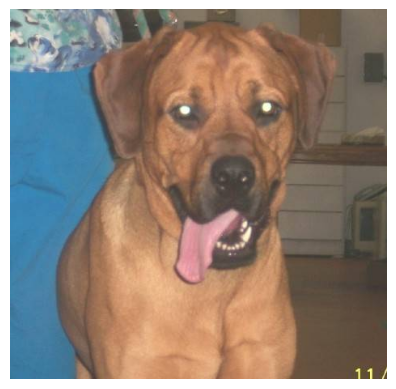

In [4]:
# Load image using OpenCV
img = cv2.imread(os.path.join(dataset_path, 'training_set/dogs', 'dog.30.jpg'))

# Print type and shape
print("Type:", type(img))
print("Shape:", img.shape)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image correctly
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()

In [5]:
# Define dataset directories
train_path = os.path.join(dataset_path, "training_set")
test_path = os.path.join(dataset_path, "test_set")

# Load Training Data
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=(256, 256),
    batch_size=16,
    color_mode="rgb"
)


# Load Testing Data
test_dataset = image_dataset_from_directory(
    test_path,
    image_size=(256, 256),
    batch_size=16,
    color_mode="rgb"
)

Found 8005 files belonging to 2 classes.


I0000 00:00:1755605520.961887      51 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13067 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080, pci bus id: 0000:01:00.0, compute capability: 12.0


Found 2023 files belonging to 2 classes.


# EDA 🔍

## Data size 📏

In [6]:
# Count batches
train_batches = tf.data.experimental.cardinality(train_dataset).numpy()
test_batches = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Training batches: {train_batches}")
print(f"Test batches: {test_batches}")
print(f"Approximate training samples: {train_batches * 16}")
print(f"Approximate test samples: {test_batches * 16}")

Training batches: 501
Test batches: 127
Approximate training samples: 8016
Approximate test samples: 2032


In [7]:
# Take one batch and examine it
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Labels dtype: {labels.dtype}")
    print(f"Image value range: {tf.reduce_min(images).numpy()} to {tf.reduce_max(images).numpy()}")
    print(f"Labels in batch: {labels.numpy()}")

Batch shape: (16, 256, 256, 3)
Labels shape: (16,)
Image dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>
Image value range: 0.0 to 255.0
Labels in batch: [0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0]


## Label Mapping 🏷

In [8]:
print("Class Names:", train_dataset.class_names)

Class Names: ['cats', 'dogs']


Class labels are assigned alphabetically by default:
- Cat → 0
- Dog → 1

## Display Some Samples 🖼

In [9]:
def display_samples(dataset, num_samples=10, batch=False):
    if batch:
        dataset = dataset.unbatch()  # Unbatch only if dataset is batched

    samples = list(dataset.take(num_samples))  # Convert to list for iteration

    plt.figure(figsize=(num_samples * 3, 3))
    for i, (image, label) in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))  # Convert tensor to NumPy and ensure correct dtype
        plt.title("Cat" if int(label.numpy()) == 0 else "Dog")  # Ensure label is an integer
        plt.axis("off")

    plt.show()

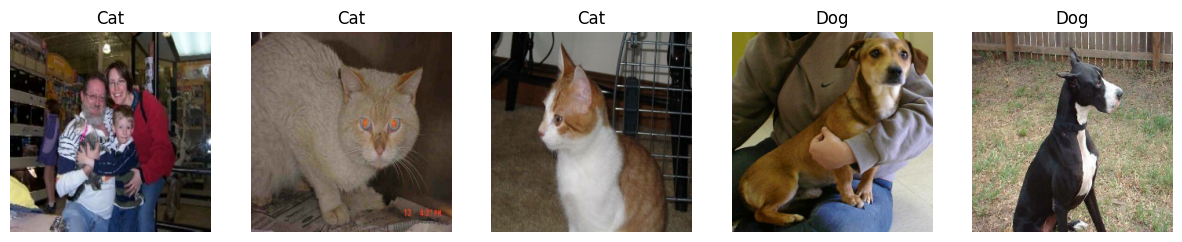

In [10]:
display_samples(train_dataset, num_samples=5, batch=True)  # Change num_samples as needed

## Class Distribution 📈

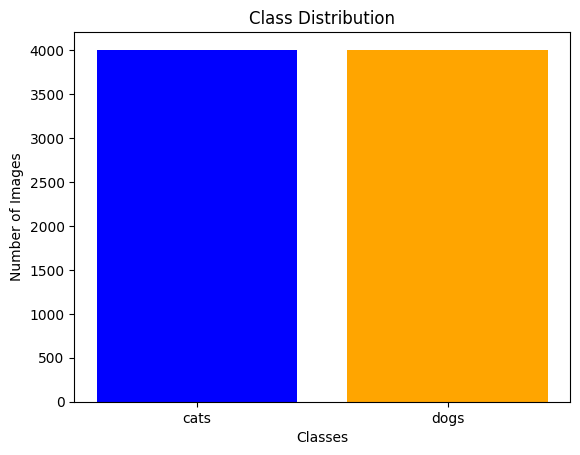

Cats: 4000 images
Dogs: 4005 images


In [11]:
# Count occurrences of each label
label_counts = collections.Counter(int(label.numpy()) for _, label in train_dataset.unbatch())

# Class names
class_names = train_dataset.class_names

# Plot class distribution
plt.bar(class_names, [label_counts[0], label_counts[1]], color=['blue', 'orange'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

# Print counts
print(f"Cats: {label_counts[0]} images")
print(f"Dogs: {label_counts[1]} images")

Our dataset is fairly balanced, so we don’t need to apply special balancing techniques

# Preprocess Data 📦

## Split Data ✂️

In [12]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Our dataset is batched because the first dimension in TensorSpec is None, meaning it represents a batch of samples.

In [13]:
# Define split ratio
train_ratio = 0.8  # 80% training, 20% validation

# Compute total batches
total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
train_size = int(total_batches * train_ratio)

# Split dataset
train_data = train_dataset.take(train_size)  # First 80% batches for training
valid_data = train_dataset.skip(train_size)  # Remaining 20% for validation

# Verify split
print(f"Training Batches: {tf.data.experimental.cardinality(train_data).numpy()}")
print(f"Validation Batches: {tf.data.experimental.cardinality(valid_data).numpy()}")

Training Batches: 400
Validation Batches: 101


## Resize and Scale 📏

In [14]:
# Define the resizing and normalization function
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label

# Apply preprocessing to the datasets
train_data = train_data.map(preprocess).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)

# Verify with a sample
for image, label in train_data.unbatch().take(1):
    print(image.shape)
    print(label)  # Corresponding label

(224, 224, 3)
tf.Tensor(1, shape=(), dtype=int32)


Now that we've explored our data, checked out some samples, and split it up, it's time to build our CNN model!

We'll start with a baseline model—a simple CNN to see how well it performs before we fine-tune things. Think of it as our starting point before we dive into optimizations. Let’s get coding! 😃

# Baseline CNN Model 🧠

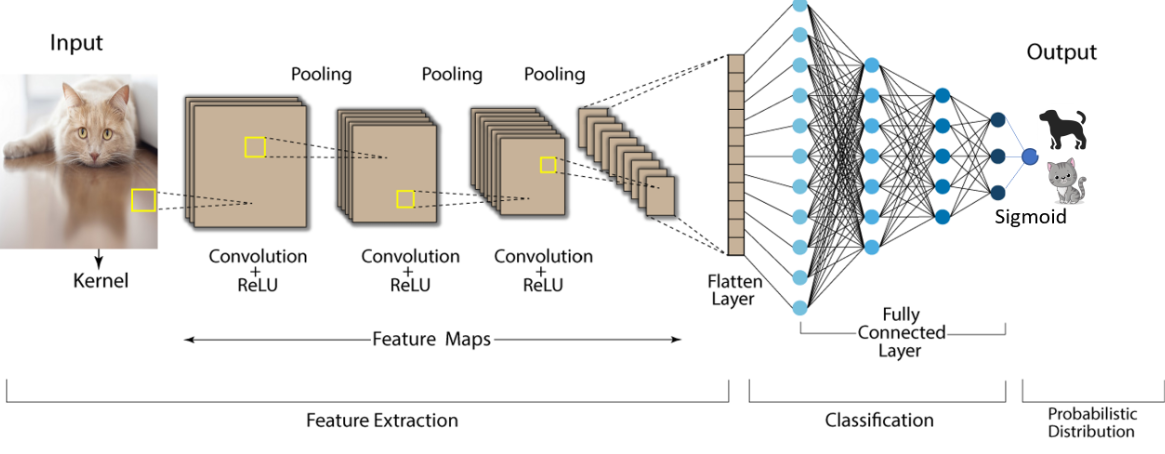

## Build 🪜

In [15]:
# del model

In [16]:
model = Sequential()

model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train 🏋️‍♂️

In [17]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5


I0000 00:00:1755605528.879496     216 cuda_dnn.cc:529] Loaded cuDNN version 90800


  9/400 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4885 - loss: 1.6286 

I0000 00:00:1755605531.822281     216 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5853 - loss: 0.6888 - val_accuracy: 0.6586 - val_loss: 0.6409
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6545 - loss: 0.6254 - val_accuracy: 0.6498 - val_loss: 0.6642
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7298 - loss: 0.5338 - val_accuracy: 0.7134 - val_loss: 0.5843
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8138 - loss: 0.3988 - val_accuracy: 0.7128 - val_loss: 0.6608
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9116 - loss: 0.2193 - val_accuracy: 0.6903 - val_loss: 0.8940


## Evaluate 🔬

In [18]:
results_cnn = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_cnn[1]*100:.2f}%")
print(f"Test Loss: {results_cnn[0]:.5f}")

Test Accuracy: 68.41%
Test Loss: 1.03523


## Plot performance 📉

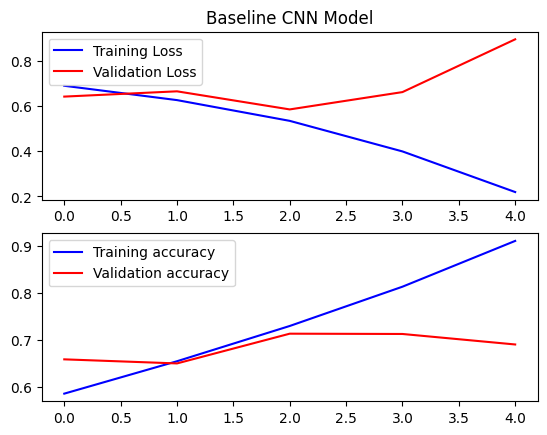

In [19]:
# plot training history
fix, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title("Baseline CNN Model")
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()
plt.show()

Our baseline CNN model is **memorizing the training data too well** but **struggling with new images**—yep, it's overfitting! 😅 It’s like a student who aces practice tests but gets confused in the real exam. Time to fine-tune and help our model **generalize better!** 🚀

# Fine-Tune CNN Model 🎯

In [20]:
model = Sequential([
    Input(shape=(224, 224, 3)),  # Changed from (256, 256, 3) to match preprocessing
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265,729 (73.49 MB)

 Trainable params: 19,264,769 (73.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [21]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6555 - loss: 0.8364 - val_accuracy: 0.5315 - val_loss: 1.6525
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7633 - loss: 0.5074 - val_accuracy: 0.7632 - val_loss: 0.5105
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8089 - loss: 0.4119 - val_accuracy: 0.7751 - val_loss: 0.5162
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8597 - loss: 0.3222 - val_accuracy: 0.8012 - val_loss: 0.4729
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9005 - loss: 0.2432 - val_accuracy: 0.7931 - val_loss: 0.5032
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9336 - loss: 0.1656 - val_accuracy: 0.8112 - val_loss: 0.5021
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9489 - loss: 0.1345 - val_accuracy: 0.8087 - val_loss: 0.5480
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9625 - loss: 0.0987 - val_acc

Test Accuracy: 80.13%
Test Loss: 0.67899


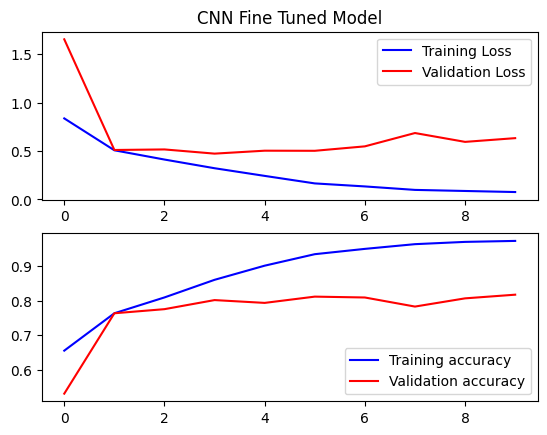

In [22]:
# Evaluate
results_cnnft = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_cnnft[1]*100:.2f}%")
print(f"Test Loss: {results_cnnft[0]:.5f}")

# plot training history
fix, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title("CNN Fine Tuned Model")
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()
plt.show()

Alright, so our fine-tuned CNN barely improved.. not exactly a game-changer 😅 To really break past 80-90%, we need something stronger! 💪 

Time to bring in transfer learning with VGG16 and MobileNetV2 and let the pre-trained models do the heavy lifting! 🚀🔥

# VGG16 📦

## Base model VGG116 🧩

In [23]:
# Load pre-trained VGG16 without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional layers

# Build model using Sequential
model_vgg16 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # Binary classification (cats vs dogs)
])

# Compile model
model_vgg16.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Train model and store history
history = model_vgg16.fit(train_data, validation_data=valid_data, epochs=5)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.8381 - loss: 0.4183 - val_accuracy: 0.9190 - val_loss: 0.2119
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.8956 - loss: 0.2515 - val_accuracy: 0.9265 - val_loss: 0.1964
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9108 - loss: 0.2128 - val_accuracy: 0.9296 - val_loss: 0.1665
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9141 - loss: 0.1957 - val_accuracy: 0.9034 - val_loss: 0.2195
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9281 - loss: 0.1679 - val_accuracy: 0.9308 - val_loss: 0.1702


Test Accuracy: 80.13%
Test Loss: 0.67899


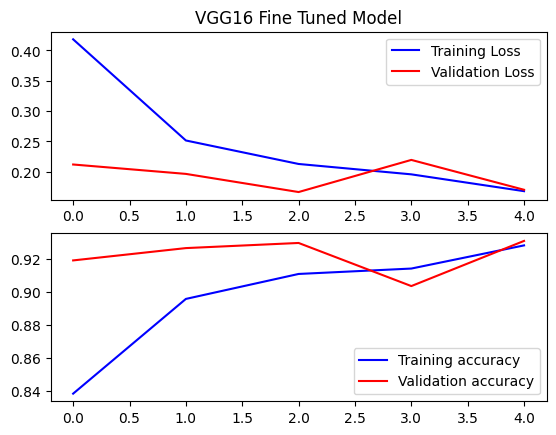

In [24]:
# Evaluate model
results_vgg16 = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_vgg16[1]*100:.2f}%")
print(f"Test Loss: {results_vgg16[0]:.5f}")

# plot training history
fix, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title("VGG16 Fine Tuned Model")
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()
plt.show()

Hummmm ..Our fine-tuned CNN and the baseline VGG16 have reached the same level of accuracy—it's a tie! 😅 But we know VGG16 has more potential.  

💪 Let’s enhance it with **data augmentation** and push beyond this barrier! 🚀🔥

## VGG16 with Data Augmentation 🎨

In [25]:
# Data Augmentation Layer (Outside .map())
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

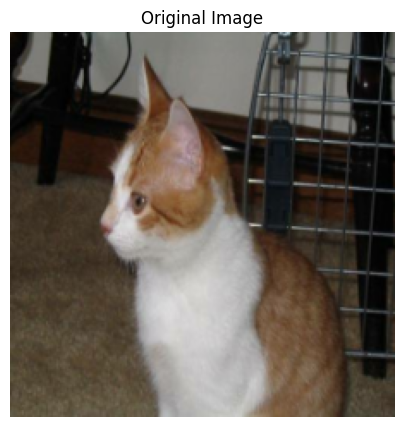

In [26]:
# Take one batch from train_data
for image_batch, label_batch in train_data.take(1):
    sample_image = image_batch[0]  # Take first image from batch
    break

# Convert tensor to numpy for visualization
sample_image = sample_image.numpy()

# Show original image
plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

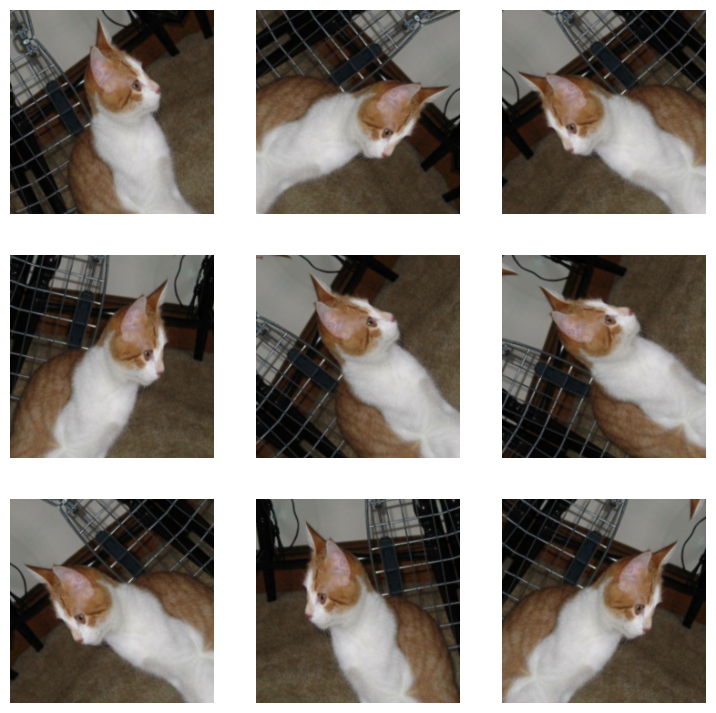

In [27]:
# Number of augmented images
num_augmented_images = 9

# Create a figure
plt.figure(figsize=(9, 9))

for i in range(num_augmented_images):
    # Apply augmentation multiple times
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))  # Add batch dimension
    augmented_image = augmented_image[0].numpy()  # Convert tensor to numpy

    # Display each augmented image
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")  # Remove axis labels

plt.show()

We’ve set up **data augmentation**, and now it’s time to put it to work! 

💪 Let’s use it with **VGG16 fine-tuning** and see if we can finally push our accuracy! 🚀🔥

In [28]:
# Load Pre-trained VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Unfreeze only the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Build Model with Data Augmentation
model_vgg16_da = Sequential([
    data_augmentation,  # Apply augmentation before feeding into VGG16
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model_vgg16_da.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Train Model
history = model_vgg16_da.fit(
    train_data,
    validation_data=valid_data,
    epochs=5
)

Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.8484 - loss: 0.3282 - val_accuracy: 0.9564 - val_loss: 0.1171
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9222 - loss: 0.1994 - val_accuracy: 0.9421 - val_loss: 0.1359
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9378 - loss: 0.1590 - val_accuracy: 0.9570 - val_loss: 0.1079
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.9422 - loss: 0.1394 - val_accuracy: 0.9539 - val_loss: 0.1139
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9552 - loss: 0.1146 - val_accuracy: 0.9433 - val_loss: 0.1314


Test Accuracy: 95.01%
Test Loss: 0.13461


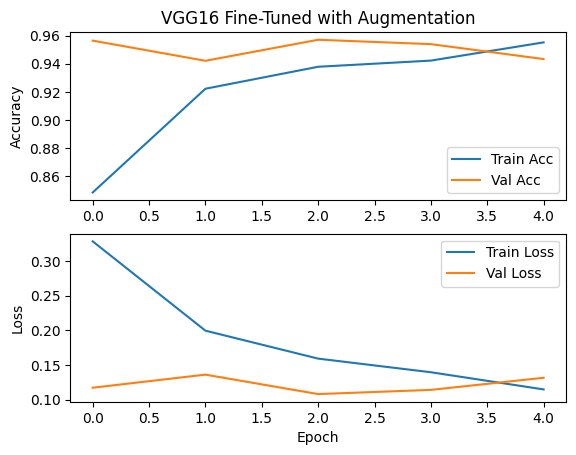

In [29]:
results_vgg16_da = model_vgg16_da.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_vgg16_da[1]*100:.2f}%")
print(f"Test Loss: {results_vgg16_da[0]:.5f}")

# Plot Training History
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('VGG16 Fine-Tuned with Augmentation')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

Boom! 💥 **95% accuracy** with fine-tuned VGG16! 🎉 

Now, let’s see if we can **push it even further** with **MobileNetV2**—a lighter, faster model that might just surprise us! 🚀🔥

# MobileNetV2 With Augmentation 🎨

## Train and Evaluate the model 🏋️‍♂️

In [30]:
# Load Pre-trained MobileNetV2 (Frozen Weights)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Keep all layers frozen

# Build Model
model_mobilev2 = Sequential([
    data_augmentation,  # Apply augmentation before MobileNetV2
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")  # Binary classification
])

# Compile Model
model_mobilev2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4 ),
                       loss="binary_crossentropy",
                       metrics=["accuracy"])

# Train Model
history = model_mobilev2.fit(
    train_data,
    epochs=5,
    validation_data=valid_data
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9275 - loss: 0.1869 - val_accuracy: 0.9801 - val_loss: 0.0601
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9525 - loss: 0.1238 - val_accuracy: 0.9788 - val_loss: 0.0579
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9556 - loss: 0.1124 - val_accuracy: 0.9819 - val_loss: 0.0504
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9536 - loss: 0.1135 - val_accuracy: 0.9832 - val_loss: 0.0492
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9578 - loss: 0.1012 - val_accuracy: 0.9807 - val_loss: 0.0478


Test Accuracy: 98.71%
Test Loss: 0.04223


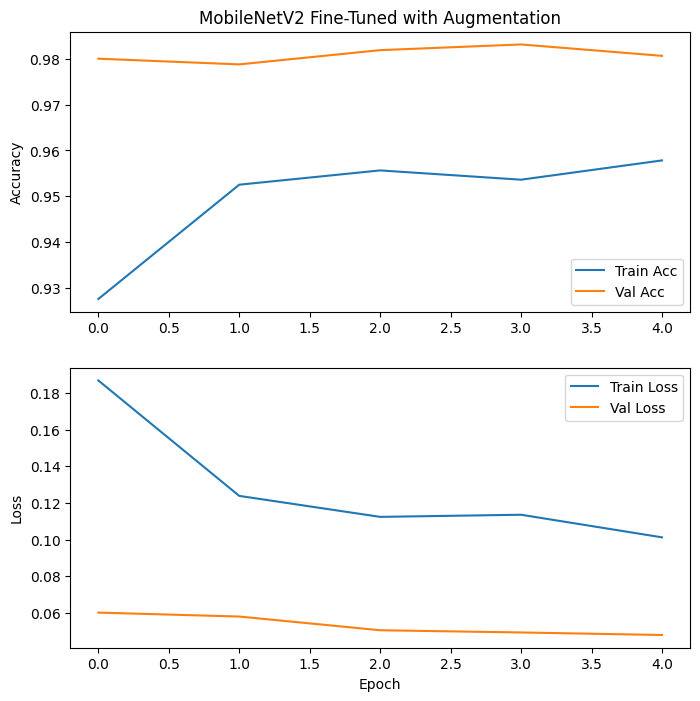

In [31]:
results_mobilev2 = model_mobilev2.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {results_mobilev2[1]*100:.2f}%")
print(f"Test Loss: {results_mobilev2[0]:.5f}")

# Plot the training history
plt.figure(figsize=(8, 8))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Fine-Tuned with Augmentation')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

🔥 BOOM! 98% ACCURACY! 🎯🚀 MobileNetV2 just crushed it! 💥

Looks like transfer learning + fine-tuning + augmentation really paid off!!

## Predictions 🔮

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


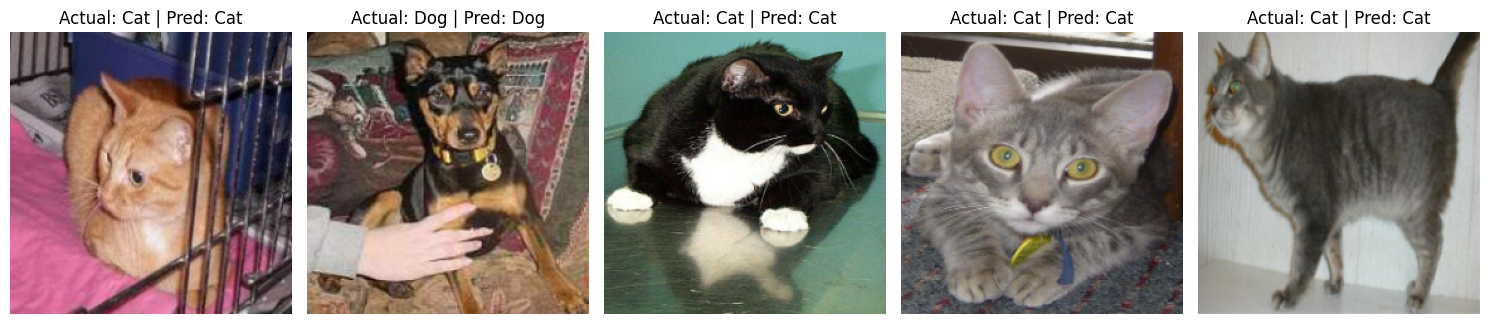

In [32]:
# Define the number of images you want to display
num_images = 5

# Create a 1-row, num_images-column grid for displaying images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate over the first batch of the test data
for images, labels in test_data.take(1):  # Take first batch from test_data
    predicted_labels = (model_mobilev2.predict(images) >= 0.5).astype(int)

    # Display the first `num_images` images in the batch with their predicted and actual labels
    for i in range(num_images):
        ax = axes[i]  # Select the axis for the current image
        ax.imshow(images[i].numpy())  # Display image
        actual_label = 'Cat' if labels[i].numpy() == 0 else 'Dog'  # Actual label
        predicted_label = 'Cat' if predicted_labels[i] == 0 else 'Dog'  # Predicted label
        ax.set_title(f"Actual: {actual_label} | Pred: {predicted_label}")  # Show labels
        ax.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Confusion Matrix - Classification report 🟠🔵

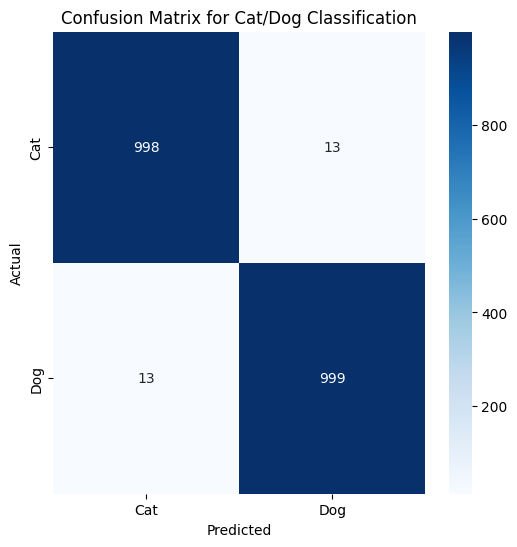

Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      1011
         Dog       0.99      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023



In [33]:
# Lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through the test data to get true labels and predictions
for images, labels in test_data:
    # Predict labels for the current batch (do this once per batch)
    predicted_labels = (model_mobilev2.predict(images,  verbose=0) >= 0.5).astype(int)

    # Collect true labels and predicted labels
    y_true.extend(labels.numpy())  # Actual labels
    y_pred.extend(predicted_labels.flatten())  # Predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Cat/Dog Classification')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# Summary 📜

In [34]:
performance = pd.DataFrame({
    'Metrics': ['Accuracy', 'Loss'],
    'CNN': [f'{results_cnn[1] * 100:.2f}%', f'{results_cnn[0]:.2f}'],
    'CNN Fine Tuned ': [f'{results_cnnft[1] * 100:.2f}%', f'{results_cnnft[0]:.2f}'],
    'VGG26': [f'{results_vgg16[1] * 100:.2f}%', f'{results_vgg16[0]:.2f}'],
    'VGG26 Augmented ': [f'{results_vgg16_da[1] * 100:.2f}%', f'{results_vgg16_da[0]:.2f}'],
    'MobileNetV2 Augmented ': [f'{results_mobilev2[1]* 100:.2f}%', f'{results_mobilev2[0]:.2f}']
})

# Print the performance DataFrame
print(performance.set_index('Metrics').T)

Metrics                Accuracy  Loss
CNN                      68.41%  1.04
CNN Fine Tuned           80.13%  0.68
VGG26                    80.13%  0.68
VGG26 Augmented          95.01%  0.13
MobileNetV2 Augmented    98.71%  0.04


Now, let’s  **save our best model for future use**, and finally, **run some predictions on external images** to see it in action! 🚀

# Run Inference ⚡

## Save the model 💾

In [35]:
model_mobilev2.save("cat_vs_dog_model.keras")

## Load the model 📥

In [36]:
model_catdog= load_model('cat_vs_dog_model.keras')

## Predict from an Image URL 🔮

In [37]:
# Preprocesses an image for model prediction
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to model input shape
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Runs model prediction
def make_prediction(img_array, model, threshold=0.6):
    prediction = model.predict(img_array, verbose=0)[0][0]  # Get probability
    confidence = abs(prediction - 0.5) * 2  # Convert to confidence score (0-1)

    if confidence < 0.4:
        most_likely_label = "Cat" if prediction < 0.5 else "Dog"
        return f"Uncertain: {most_likely_label}", confidence  # Show uncertainty + likely label

    binary_label = int(prediction >= 0.5)  # Convert probability to binary label
    predicted_label = "Cat" if binary_label == 0 else "Dog"

    return predicted_label, confidence  # Return label + confidence

# Displays the image with the predicted label and confidence percentage
def display_prediction(img, predicted_label, confidence):
    plt.imshow(img)
    plt.title(f"{predicted_label} ({confidence*100:.1f}% confidence)")
    plt.axis("off")
    plt.show()

In [38]:
# Predict an image from a URL
def predict_image_from_url(url, model):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Handle bad responses

        # Check if content type is an image
        if "image" not in response.headers["Content-Type"]:
            print("Error: URL does not contain a valid image.")
            return None

        response.raw.decode_content = True

        with Image.open(response.raw).convert("RGB") as img:
            img_array = preprocess_image(img)
            predicted_label, confidence = make_prediction(img_array, model)

            display_prediction(img, predicted_label, confidence)
            return predicted_label

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return None
    except PIL.UnidentifiedImageError:
        print("Error: The image file could not be identified. Ensure the URL points to a valid image.")
        return None

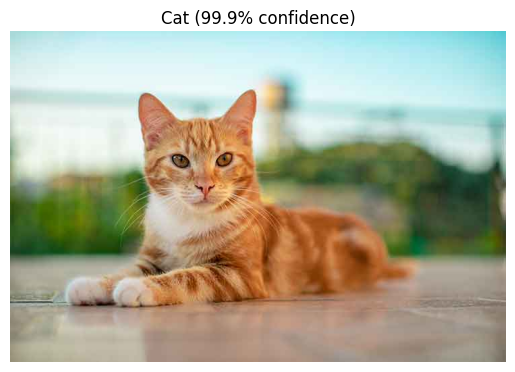

'Cat'

In [39]:
url = "https://vetmarlborough.co.nz/wp-content/uploads/cat-facts.jpg"
predict_image_from_url(url, model_catdog)

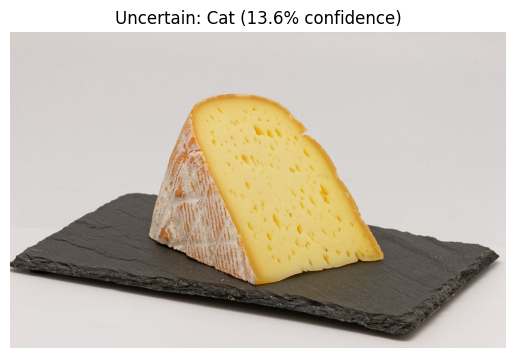

'Uncertain: Cat'

In [40]:
url = "https://radiomontblanc.fr/photos/articles/vignettes/fromage-pyrenees-bethmale_47828.jpg"
predict_image_from_url(url, model_catdog)

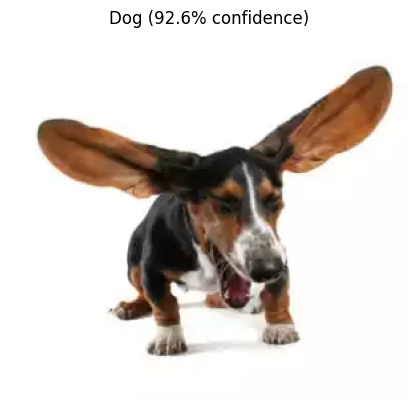

'Dog'

In [41]:
url = "https://lacvets.com/wp-content/uploads/2021/05/dog-sneezing-in-lakeland-fl-300x279.jpg"
predict_image_from_url(url, model_catdog)

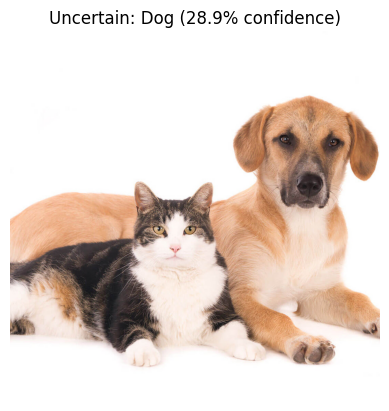

'Uncertain: Dog'

In [42]:
url = "https://petzpark.com.au/cdn/shop/articles/Dog-and-Cat-Stress_900x.jpg?v=1660605269"
predict_image_from_url(url, model_catdog)